*Импорт основных пакетов*

In [240]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

*экспорт данных для модели*

In [241]:
train = pd.read_csv("train.tsv", sep='\t')
train.head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем...,0
9,Microsoft объявила дату выхода очков дополненн...,0


In [242]:
train.describe()

,is_fake
count,5758.000000
mean,0.500000
std,0.500043
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Выведем wordcloud для отображения наиболее частых слов в фейковых и реальных новостях

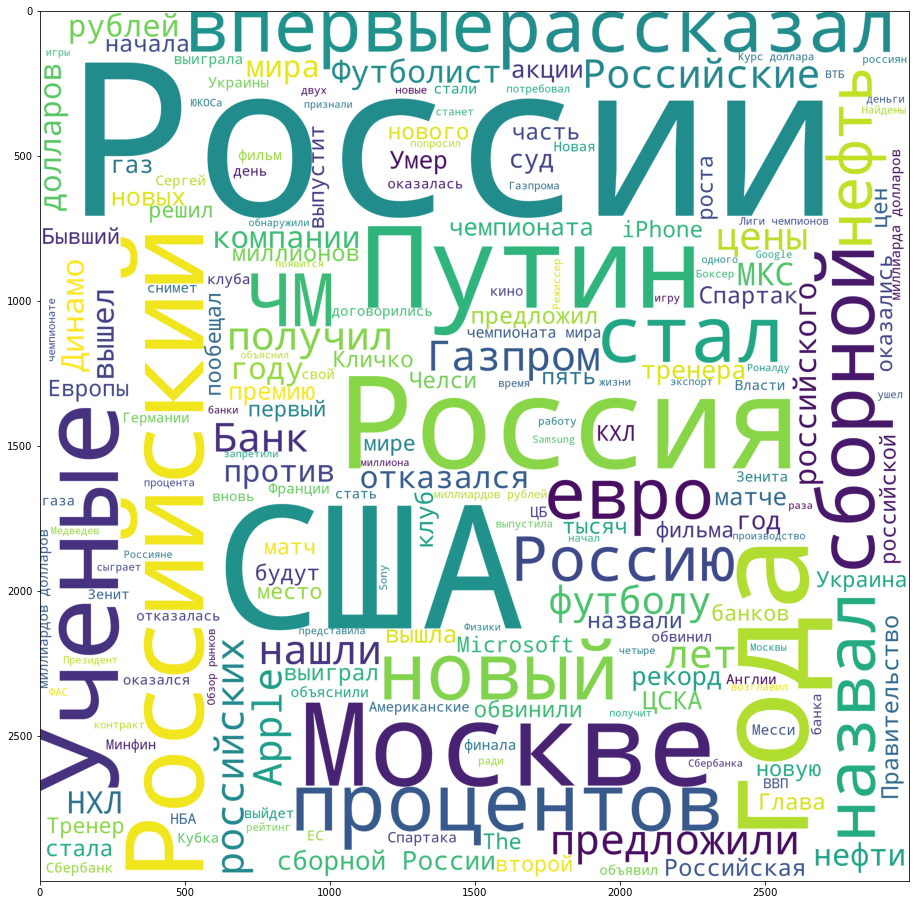

In [308]:
from collections import Counter
from nltk.corpus import stopwords

titles =  train[train['is_fake'] != 1].title
cloud = Counter(titles)
from wordcloud import WordCloud
stopwords = stopwords.words('russian')
cloud = ''
for x in list(titles):
    cloud+=x+' '
wordcloud = WordCloud(width = 3000, height = 3000, 

                stopwords = stopwords, 
                min_font_size = 2,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)

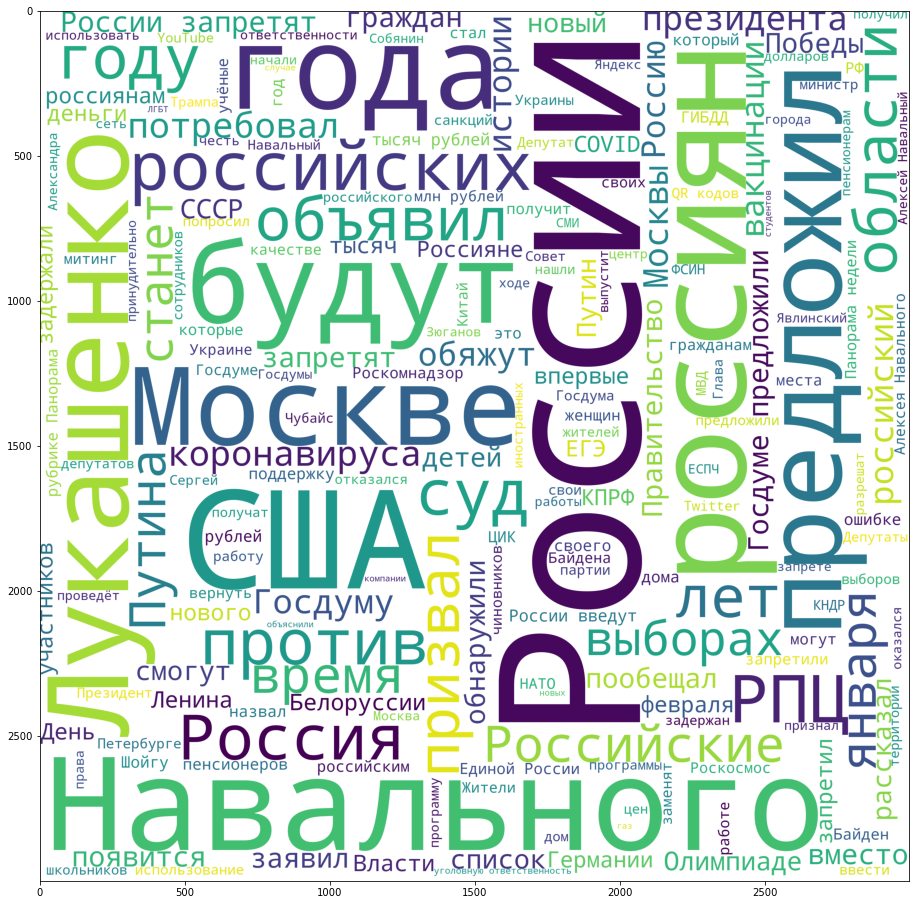

In [311]:
from collections import Counter

titles =  train[train['is_fake'] == 1].title
cloud = Counter(titles)
from wordcloud import WordCloud

cloud = ''
for x in list(titles):
    cloud+=x+' '
wordcloud = WordCloud(width = 3000, height = 3000, 
                      stopwords=stopwords,
                min_font_size = 2,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)

**Вывод:** как можно заметить в фейковых новостях в отличие от реальных преобладают слова: Лукашенко, Навального

*Разделяем выборку на тестовую и тренировочную для расчета предиктивной силы модели*

In [243]:
X_train, X_test, y_train, y_test = train_test_split(train['title'], train['is_fake'])

**Построение модели классификации**

*Представляем заголовки статей в векторном виде, по одной граммеме, и проводим стандартизацию*

In [244]:
vec = CountVectorizer(ngram_range=(1, 1))
train_words = vec.fit_transform(X_train)
test_words = vec.transform(X_test)

scaler = MaxAbsScaler()
train_words = scaler.fit_transform(train_words)
test_words = scaler.fit_transform(test_words)

*В качестве классификатора используем логистическую регрессию, которая отлично справляется с задачей бинарной классификации*

In [245]:
clf = LogisticRegression(max_iter=200, random_state=12).fit(train_words, y_train)
pred = clf.predict(test_words)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       719
           1       0.84      0.78      0.81       721

    accuracy                           0.82      1440
   macro avg       0.82      0.82      0.82      1440
weighted avg       0.82      0.82      0.82      1440



**Вывод:** *значения f1-score равны 0,84, достаточно высокое значение, однако, следует рассчитать метрику для граммем большей величины*

In [246]:
vec_1 = CountVectorizer(ngram_range=(3, 3))
train_words_1 = vec_1.fit_transform(X_train)
test_words_1 = vec_1.transform(X_test)

scaler = MaxAbsScaler()
train_words_1 = scaler.fit_transform(train_words_1)
test_words_1 = scaler.fit_transform(test_words_1)

In [247]:
clf_1 = LogisticRegression(max_iter=200, random_state=12).fit(train_words_1, y_train)
pred_1 = clf_1.predict(test_words_1)
print(classification_report(y_test, pred_1))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       719
           1       0.94      0.07      0.13       721

    accuracy                           0.53      1440
   macro avg       0.73      0.53      0.40      1440
weighted avg       0.73      0.53      0.40      1440



**Вывод:** *показатель f1-score снизился, т.к. модель захватывает большую часть заголовка и переобучается*

*Попробуем применить другой способ векторизации* **TfIdf**

In [248]:
vec_2 = TfidfVectorizer(ngram_range=(1, 1))
train_words_2 = vec_2.fit_transform(X_train)
test_words_2 = vec_2.transform(X_test)

scaler = MaxAbsScaler()
train_words_2 = scaler.fit_transform(train_words_2)
test_words_2 = scaler.fit_transform(test_words_2)

In [249]:
clf_2 = LogisticRegression(max_iter=300, random_state=42).fit(train_words_2, y_train)
pred_tfidf = clf_2.predict(test_words_2)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       719
           1       0.85      0.77      0.81       721

    accuracy                           0.82      1440
   macro avg       0.82      0.82      0.82      1440
weighted avg       0.82      0.82      0.82      1440



**Вывод:** *f1-score не улучшился относительно первоначальной модели, однако точность и полнота модели смогли достичь значений 0,9 и 0,91, соответственно**

**Токенизация текста**

*Разобьем элементы заголовков на токены и попробуем обучить модель*

In [250]:
from nltk.tokenize import word_tokenize

In [251]:
vec_3 = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
train_words_3 = vec_3.fit_transform(X_train)
test_words_3 = vec_3.transform(X_test)

scaler = MaxAbsScaler()
train_words_3 = scaler.fit_transform(train_words_3)
test_words_3 = scaler.fit_transform(test_words_3)

In [252]:
clf_3 = LogisticRegression(max_iter=300, random_state=42).fit(train_words_3, y_train)
pred_3 = clf_3.predict(test_words_3)
print(classification_report(y_test, pred_3))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       719
           1       0.86      0.81      0.83       721

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



**f1-score увеличился на 0,01, что является значимым улучшением**

Теперь попробуем привести слова к начальному виду. 

Не стоит исключать пунктуацию, т.к. именно такие элементы могут передавать эмоциональный окрас заголовка.
"Стопслова" стоит исключить, т.к. они в равной степени встречаются и в реальных статьях.

In [253]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [254]:
X_train_tokenized = X_train.apply(lambda x: word_tokenize(x)).reset_index(drop=True)
X_test_tokenized = X_test.apply(lambda x: word_tokenize(x)).reset_index(drop=True)

In [255]:
for t in range(len(X_train_tokenized)):
    for w in range(len(X_train_tokenized[t])):
        X_train_tokenized[t][w] = (pymorphy2_analyzer.parse(X_train_tokenized[t][w])[0].normal_form)
        
for w in range(len(X_train_tokenized)):
    X_train_tokenized[w] = " ".join(X_train_tokenized[w])

In [256]:
X_train_tokenized.sample(10)

2115    в россия возбудить первый дело за невыплата ав...
912     шуховсковать башня на ока признать памятник фе...
2342    пермский хабад пригрозить сила снять звезда да...
3936    в сша арестовать порноактёр из brazzers , прин...
1542    устроить пробка контейнеровоз не выпустить из ...
1118    врач республика алтай выделить время и место ,...
2577                     гохран провести алмазный аукцион
2841    гражданин трудоспособный возраст законодательн...
4024    организатор « евровидение » объяснить причина ...
2772    « почта россия » планировать увеличить чистый ...
Name: title, dtype: object

In [257]:
for t in range(len(X_test_tokenized)):
    for w in range(len(X_test_tokenized[t])):
        X_test_tokenized[t][w] = (pymorphy2_analyzer.parse(X_test_tokenized[t][w])[0].normal_form)
        
for w in range(len(X_test_tokenized)):
    X_test_tokenized[w] = " ".join(X_test_tokenized[w])

In [320]:
vec_4 = CountVectorizer(ngram_range=(1, 1),tokenizer=word_tokenize,stop_words=stopwords)
train_words_4 = vec_4.fit_transform(X_train_tokenized)
test_words_4 = vec_4.transform(X_test_tokenized)

scaler = MaxAbsScaler()
train_words_4 = scaler.fit_transform(train_words_4)
test_words_4 = scaler.fit_transform(test_words_4)

In [321]:
clf_4 = LogisticRegression(max_iter=300, random_state=42).fit(train_words_4, y_train)
pred_4 = clf_4.predict(test_words_4)
print(classification_report(y_test, pred_4))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       719
           1       0.88      0.84      0.86       721

    accuracy                           0.86      1440
   macro avg       0.86      0.86      0.86      1440
weighted avg       0.86      0.86      0.86      1440



In [260]:
import numpy as np

In [345]:
vec_4.get_feature_names()[np.argmax(clf_4.coef_)]

','

**Вывод:** как можно заметить, наиболее сильное влияние на классификацию статьи оказывает "запятая". Это связано с тем, что фейковые статьи зачастую имеют эмоциональный окрас и множество оборотов, которые могут быть неуместны. В то же самое время **f1-score** составил **0,86**

**Выводим результат в виде предсказаний на основе обученной модели**

In [346]:
predictions = pd.read_csv('test.tsv', sep='\t')

In [347]:
X_pred = predictions['title']
X_pred = X_pred.apply(lambda x: word_tokenize(x))
for t in range(len(X_pred)):
    for w in range(len(X_pred[t])):
        X_pred[t][w] = (pymorphy2_analyzer.parse(X_pred[t][w])[0].normal_form)
        
for w in range(len(X_pred)):
    X_pred[w] = " ".join(X_pred[w])

In [348]:
X = train['title']
y = train['is_fake']
X_tokenized = X.apply(lambda x: word_tokenize(x))
for t in range(len(X_tokenized)):
    for w in range(len(X_tokenized[t])):
        X_tokenized[t][w] = (pymorphy2_analyzer.parse(X_tokenized[t][w])[0].normal_form)
        
for w in range(len(X_tokenized)):
    X_tokenized[w] = " ".join(X_tokenized[w])

In [349]:
vec_final = CountVectorizer(ngram_range=(1, 1),tokenizer=word_tokenize, stop_words=stopwords)
words = vec_final.fit_transform(X_tokenized)
words_pred = vec_final.transform(X_pred)

scaler = MaxAbsScaler()
words = scaler.fit_transform(words)
words_pred = scaler.fit_transform(words_pred)

In [350]:
clf_final = LogisticRegression(max_iter=300, random_state=42).fit(words, y)
pred_final = clf_final.predict(words_pred)


In [351]:
predictions['is_fake'] = pred_final

In [352]:
predictions.to_csv("predictions.tsv",sep='\t')